In [3]:
import numpy as np
import cv2
import os
import string
import matplotlib.pyplot as plt
import tqdm
from os.path import join
from collections import Counter
import re 
import io
import copy
from tensorflow.keras import layers
import editdistance

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers

from tensorflow.keras.layers import Dense, LSTM,GRU, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu, sigmoid, softmax
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

Versions.

In [5]:
import keras
import tensorflow as tf
print('TensorFlow version:', tf.__version__)
print('Keras version:', keras.__version__)

TensorFlow version: 2.2.0
Keras version: 2.4.3


In [8]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=28000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    #physical_devices = tf.config.list_physical_devices('GPU')
    #tf.config.experimental.set_memory_growth(physical_devices[0], True)

* CUDA 10.1
* cv2 4.3.0
* numpy 1.19.2
* re 2.2.1
* tqdm 4.46.0
* matplotlib 3.3.2



* Nvidia Tesla V100 32Gb

**Path for images ant labels.**

In [6]:
#This foler contains txt files with translation 
trans_dir = 'data/words'
#This folder contains jpg images
image_dir = 'data/images'

print(len(os.listdir(trans_dir)))

9694


Show one image.

In [10]:
example = os.listdir(image_dir)[0]

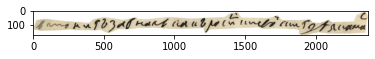

In [11]:
img = plt.imread(image_dir+'/'+example)
plt.imshow(img)
plt.show()

And translation.

In [9]:
with io.open(trans_dir+'/'+example[:-3]+'txt', 'r',  encoding='utf8') as file:
    data = file.read()

print(data)

в тонигъ загналъ какъ росиские войски гдѣ я каман


Peter is a dataset of russian language. But there is some english letter. Here in baseline we drop lines that contains english letters. It allows us to reduce the number of unique symbols. We do it only for train set.

In [14]:
english = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'm', 'n' ,'o', 'p', 'r', 's', 't', 'u', 'w']

In [15]:
def text_to_labels(text):
    return list(map(lambda x: letters.index(x), text))

Here we prepare labels (translated text). Ignore lines with english letters.

In [16]:
def process_texts(image_dir,trans_dir):
    lens = []
    include_english = 0
    letters = ''

    lines = []
    names = []
    
    all_files = os.listdir(trans_dir)
    for filename in os.listdir(image_dir):
        if filename[:-3]+'txt' in all_files:
            name, ext = os.path.splitext(filename)
            txt_filepath = join(trans_dir, name + '.txt')
            with open(txt_filepath, 'r') as file:
                data = file.read()
                if len(data)==0:
                    continue
                if len(set(data).intersection(english))>0:
                    continue

                lines.append(data)
                names.append(filename)
                lens.append(len(data))
                letters += data
    print('Max string length:', max(Counter(lens).keys()))
    print('Number of lines with english letters (we drop it) ',include_english)

    return names,lines,Counter(letters)

So we get list of images (filenames), list of translated lines and the character dictionary.

In [17]:
names,lines,cnt = process_texts(image_dir,trans_dir)

Max string length: 76
Number of lines with english letters (we drop it)  0


In [18]:
letters = set(cnt.keys())

letters = sorted(list(letters))
print('Unique characters in train:', ' '.join(letters))

Unique characters in train:   # ( ) + / 0 1 2 3 4 5 6 7 8 9 [ ] i k l | × ǂ а б в г д е ж з и й к л м н о п р с т у ф х ц ч ш щ ъ ы ь э ю я ѣ – ⊕ ⊗


Here we load images, resize and normalize it.

In [19]:
def process_image(img):
    w, h,_ = img.shape
    
    new_w = 128
    new_h = int(h * (new_w / w))
    img = cv2.resize(img, (new_h, new_w))
    w, h,_ = img.shape
    
    img = img.astype('float32')
    
    if w < 128:
        add_zeros = np.full((128-w, h,3), 255)
        img = np.concatenate((img, add_zeros))
        w, h,_ = img.shape
    
    if h < 1024:
        add_zeros = np.full((w, 1024-h,3), 255)
        img = np.concatenate((img, add_zeros), axis=1)
        w, h,_ = img.shape
        
    if h > 1024 or w > 128:
        dim = (1024,128)
        img = cv2.resize(img, dim)
    
    img = cv2.subtract(255, img)

    img = img / 255
    
    return img

**Prepare data.**

In [20]:
def generate_data(lines,names,image_dir):
    data_images = []
    data_labels = []
    data_input_length = []
    data_label_length = []
    data_original_text = []
    #data_original_image = []
    
    max_label_len = 0
    for line, name in tqdm.tqdm_notebook(zip(lines,names)):
        img = cv2.imread(image_dir+'/'+name)
        #original_image = copy.deepcopy(img)
        img = process_image(img)
        try:
            label = text_to_labels(line)
        except:
            print('bad_label')
            continue
        data_images.append(img)
        data_labels.append(label)
        data_input_length.append(255)
        data_label_length.append(len(line))
        data_original_text.append(line)
        #data_original_image.append(original_image)
        
        if len(line) > max_label_len:
            max_label_len = len(line)
        
    return data_images, data_labels, data_input_length, data_label_length, \
            data_original_text, max_label_len

Create train set and val set.

In [21]:
lines_train = []
names_train = []

lines_val = []
names_val = []


for num,(line, name) in enumerate(zip(lines,names)):
    if num % 15 == 0:
        lines_val.append(line)
        names_val.append(name)
    else:
        lines_train.append(line)
        names_train.append(name)

In [22]:
train_images, train_labels, train_input_length, train_label_length, train_original_text, \
        train_max_label_len = generate_data(lines_train, names_train, image_dir)

/home/user/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


In [23]:
val_images, val_labels, val_input_length, val_label_length, val_original_text, \
        val_max_label_len = generate_data(lines_val, names_val, image_dir)

/home/user/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


In [24]:
max_label_len = max(train_max_label_len,val_max_label_len)
print(max_label_len)

76


A couple of processed images with translation.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


тивом призрѣниi со


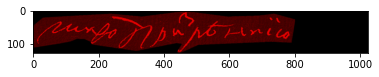

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ми свинцовыми


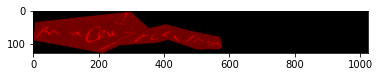

In [25]:
rnd = np.random.choice(range(len(train_images)),2)

for i in rnd:
    print(train_original_text[i])
    plt.imshow(train_images[i])
    plt.show()

**Pad labels to maximun length**

In [26]:
train_padded_label = pad_sequences(train_labels, 
                             maxlen=max_label_len, 
                             padding='post',
                             value=len(letters))

val_padded_label = pad_sequences(val_labels, 
                             maxlen=max_label_len, 
                             padding='post',
                             value=len(letters))

In [27]:
train_padded_label.shape, val_padded_label.shape

((8928, 76), (638, 76))

Takes a lot of time.

In [ ]:
train_images = np.asarray(train_images)
train_input_length = np.asarray(train_input_length)
train_label_length = np.asarray(train_label_length)

val_images = np.asarray(val_images)
val_input_length = np.asarray(val_input_length)
val_label_length = np.asarray(val_label_length)

In [36]:
train_images.shape

(8928, 128, 1024, 3)

## **Model**

The model consists of several CNN, GRU layers and use CTC-Loss.

In [37]:
inputs = Input(shape=(128,1024,3))

conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
pool_1 = MaxPool2D(pool_size=(4, 2), strides=2)(conv_1)

conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(4, 2), strides=2)(conv_2)

conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)

conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)

pool_4 = MaxPool2D(pool_size=(4, 1),padding='same')(conv_4)

conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)

batch_norm_5 = BatchNormalization()(conv_5)

conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(4, 1),padding='same')(batch_norm_6)

conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)

squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)

blstm_1 = Bidirectional(GRU(256, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(GRU(256, return_sequences=True, dropout = 0.2))(blstm_1)

outputs = Dense(len(letters)+1, activation = 'softmax')(blstm_2)
act_model = Model(inputs=inputs, outputs=outputs)
    
the_labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args

    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, the_labels, input_length, label_length])

model = Model(inputs=[inputs, the_labels, input_length, label_length], outputs=loss_out)

In [38]:
act_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 1024, 3)]    0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 128, 1024, 64)     1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 512, 64)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 63, 512, 128)      73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 256, 128)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 30, 256, 256)      295168    
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 30, 256, 256)      5900

In [39]:
batch_size = 60
epochs = 300

from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam', metrics=['accuracy'])

os.makedirs('checkpoint', exist_ok=True)

filepath="checkpoint/model.hdf5"

In [28]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.7,
                              patience=5, min_lr=0.00001)

checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint,es,reduce_lr]

history = model.fit(x=[train_images, train_padded_label, train_input_length, train_label_length],
                    y=np.zeros(len(train_images)),
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data=([val_images, val_padded_label, val_input_length, val_label_length], [np.zeros(len(val_images))]),
                    verbose=2,
                    callbacks=callbacks_list)


Epoch 1/300

Epoch 00001: val_accuracy improved from -inf to 0.00000, saving model to checkpoint/model.hdf5
149/149 - 77s - loss: 104.3876 - accuracy: 0.0000e+00 - val_loss: 96.3332 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/300

Epoch 00002: val_accuracy did not improve from 0.00000
149/149 - 70s - loss: 89.1907 - accuracy: 0.0000e+00 - val_loss: 95.7020 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/300

Epoch 00003: val_accuracy did not improve from 0.00000
149/149 - 71s - loss: 82.0753 - accuracy: 0.0000e+00 - val_loss: 124.4885 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/300

Epoch 00004: val_accuracy did not improve from 0.00000
149/149 - 69s - loss: 43.9647 - accuracy: 0.0000e+00 - val_loss: 82.0149 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 5/300

Epoch 00005: val_accuracy did not improve from 0.00000
149/149 - 70s - loss: 20.9432 - accuracy: 0.0021 - val_loss: 32.4083 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 6/300

Epoch 00006: val_accuracy improved from 0.00

Look at val metrics.

In [40]:
import time

In [41]:
start = time.time()
act_model.load_weights(filepath)
prediction = act_model.predict(val_images)

decoded = K.ctc_decode(prediction, 
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                       greedy=True)[0][0]
out = K.get_value(decoded)
end = time.time()
print(end-start)

5.158626556396484


In [42]:
numCharErr = 0
numCharTotal = 0
numStringOK = 0
numStringTotal = 0

word_eds, word_true_lens = [], []

print('Ground truth -> Recognized')	
for i in range(len(out)):
    pred = ''
    for p in out[i]:
        if int(p) != -1:
            pred+=letters[int(p)]
    true = val_original_text[i]
    
    numStringOK += 1 if true == pred else 0
    numStringTotal += 1
    dist = editdistance.eval(pred, true)
    numCharErr += dist
    numCharTotal += len(true)
    
    pred_words = pred.split()
    true_words = true.split()
    word_eds.append(editdistance.eval(pred_words, true_words))
    word_true_lens.append(len(true_words))
    
    print('[OK]' if dist==0 else '[ERR:%d]' % dist,'"' + true + '"', '->', '"' + pred + '"')

charErrorRate = numCharErr / numCharTotal
wordErrorRate = sum(word_eds) / sum(word_true_lens) 
stringAccuracy = numStringOK / numStringTotal
print('Character error rate: %f%%. Word error rate: %f%%. String accuracy: %f%%.' % \
      (charErrorRate*100.0,wordErrorRate*100.0, stringAccuracy*100.0))

Ground truth -> Recognized
[ERR:3] "в тонигъ загналъ какъ росиские войски гдѣ я каман" -> "в кониюъ загналъ какъ росиские войски гдѣя каман"
[ERR:4] "дѣла же оное iмѣет быт по сему перво надлежит" -> "дѣла же оное iмѣет бы го сему перлонадлежит"
[OK] "крѣпости тыся" -> "крѣпости тыся"
[OK] "шал что наши там з голоду поми" -> "шал что наши там з голоду поми"
[ERR:1] "а над ними съ губерниi камисар" -> "а надними съ губерниi камисар"
[ERR:3] "со фъсѣ войском вошел при котором доволное число" -> "софъсѣ войском вошел прикотором доволнае число"
[ERR:2] "буде же ночь то в одном пушечном перестрѣле" -> "буде же но чѣ то в одном пушечном перестрѣле"
[ERR:2] "каз iли камисарам" -> "каз iликами сарам"
[ERR:5] "а нынѣ вкратце пишу что не описаны преiз" -> "а нынѣ вкратце пишу что не отиияншу преiз"
[OK] "учинит] i тѣм лутчюю выгоду" -> "учинит] i тѣм лутчюю выгоду"
[ERR:1] "теля iз вассы выбит буде же крѣпъ" -> "теля iз вассы выбит будеже крѣпъ"
[OK] "ген i отака стралзунта" -> "ген i отака стра